## equilibrar todos os niveis de fadiga e de sexos, usando replicacao de obs

### o smote não é bom pq cria variaveis continuas mesmo quando sao ordinais

### Import of libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
        "text.usetex": True,              # If you want to use LaTeX fonts in text
        "font.family": "serif",           # IEEE uses Times New Roman-like fonts
        "font.size": 12,                   # General font size for IEEE format
        "axes.labelsize": 12,              # Axis labels font size
        "legend.fontsize": 11,             # Legend font size
        "xtick.labelsize": 11,             # X-axis tick labels font size
        "ytick.labelsize": 11,             # Y-axis tick labels font size
        "figure.figsize": (5, 5*0.8),
        "savefig.dpi": 1200,               # DPI for high-quality PNG/JPEG
        "figure.dpi": 50#200,
    })

### Reading of the file and one of the sheets

In [3]:
# The athletes' names are hiden, and only the initial name and gender are visible through the naming of each dataset

Athletes = {'F_f': '',
            'J_f': '',
            'F_m': '',
            'G_m': '',
            'V_f': '',
            'A_m': '',
            'I_f': ''
            }

# Importing the data to the Athletes dictionary
for i in Athletes:
    Athletes[i] = pd.read_excel('DataFatigInd.xlsx', sheet_name = i)
    Athletes[i]['Diferença Peso'] = Athletes[i]['Peso basal'].pct_change()
    Athletes[i]['Diferença Pulso'] = Athletes[i]['Pulso após 2 horas'] - Athletes[i]['Pulso basal']
    Athletes[i].rename(columns={'Data': 'Date',
                                'Nr dia': 'NrDay',
                                'Qualidade de Sono': 'QSleep',
                                'Horas de Cama': 'TSleep',
                                'Apetite': 'Appetite',
                                'Estado de Ânimo': 'StSpirit',
                                'Percepção Carga': 'pEffort',
                                'Pulso após 2 horas': 'ATHr',
                                'Pulso basal': 'Hr',
                                'U.A. Intensidade': 'uaI',
                                'ÍNDICE DE FADIGA': 'FatigInd',
                                'Peso basal': 'Wt',
                                'Diferença Peso': 'DeltaWt (%)',
                                'Diferença Pulso': 'DeltaHrtwo'
                                }, inplace=True)
    Athletes[i]["Name"] = i
    Athletes[i]["Sex_F"] = 1 if i[-1] == "f" else 0
    Athletes[i]["SleepInd"] =  Athletes[i]["QSleep"] - Athletes[i]["TSleep"]

    
    # Compute the EWMA3
    lam3 = 2 / (3+1)
    for feature in ['uaI', 'SleepInd', 'StSpirit', 'pEffort', 'DeltaWt (%)', 'Appetite']:
        for j in range(len(Athletes[i])):
            if j == 0:
                # Initialize the first value as just the first uaI
                Athletes[i].loc[j, f'{feature}(MA3)'] = Athletes[i].loc[j, f'{feature}'] if not np.isnan(Athletes[i].loc[j, f'{feature}']) else 0
            else:
                Athletes[i].loc[j, f'{feature}(MA3)'] = (
                    Athletes[i].loc[j, f'{feature}'] * lam3 + (1 - lam3) * Athletes[i].loc[j-1, f'{feature}(MA3)']
                    )
    # Compute the EWMA6
    lam6 = 2 / (6+1)
    for feature in ['uaI', 'SleepInd', 'StSpirit', 'pEffort', 'DeltaWt (%)', 'Appetite']:
        for j in range(len(Athletes[i])):
            if j == 0:
                # Initialize the first value as just the first uaI
                Athletes[i].loc[j, f'{feature}(MA6)'] = Athletes[i].loc[j, f'{feature}'] if not np.isnan(Athletes[i].loc[j, f'{feature}']) else 0
            else:
                Athletes[i].loc[j, f'{feature}(MA6)'] = (
                    Athletes[i].loc[j, f'{feature}'] * lam6 + (1 - lam6) * Athletes[i].loc[j-1, f'{feature}(MA6)']
                    )
    
    Athletes[i]['uaI(-1)'] =  Athletes[i]['uaI'].shift(1)
    Athletes[i]['SleepInd(-1)'] =  Athletes[i]['SleepInd'].shift(1)
    Athletes[i]['StSpirit(-1)'] =  Athletes[i]['StSpirit'].shift(1)
    Athletes[i]['pEffort(-1)'] =  Athletes[i]['pEffort'].shift(1)
    Athletes[i]['DeltaWt (%)(-1)'] =  Athletes[i]['DeltaWt (%)'].shift(1)
    Athletes[i]['Appetite(-1)'] =  Athletes[i]['Appetite'].shift(1)
    print(i, Athletes[i].shape)
    
df = pd.concat(Athletes.values(), ignore_index=True)
df.drop(columns=['NrDay', 'QSleep', 'TSleep', 'Hr', 'ATHr', 'Wt'], inplace=True)

df

F_f (212, 35)
J_f (212, 35)
F_m (212, 35)
G_m (93, 35)
V_f (174, 35)
A_m (157, 35)


/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_3229/3740280774.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  Athletes[i]['Diferença Peso'] = Athletes[i]['Peso basal'].pct_change()


I_f (212, 35)


,Date,Appetite,StSpirit,pEffort,uaI,FatigInd,DeltaWt (%),DeltaHrtwo,Name,Sex_F,...,StSpirit(MA6),pEffort(MA6),DeltaWt (%)(MA6),Appetite(MA6),uaI(-1),SleepInd(-1),StSpirit(-1),pEffort(-1),DeltaWt (%)(-1),Appetite(-1)
0,2019-10-18,6.0,4.0,6.0,1.76,99.809325,NaN,2.0,F_f,1,...,4.000000,6.000000,0.000000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-10-19,7.0,7.0,7.0,1.66,87.095325,0.000000,-6.0,F_f,1,...,4.857143,6.285714,0.000000,6.285714,1.76,-3.50,4.0,6.0,NaN,6.0
2,2019-10-20,7.0,3.0,4.0,1.42,50.660225,0.000000,6.0,F_f,1,...,4.326531,5.632653,0.000000,6.489796,1.66,-7.00,7.0,7.0,0.0,7.0
3,2019-10-21,5.0,3.0,4.0,2.03,64.996625,0.000000,0.0,F_f,1,...,3.947522,5.166181,0.000000,6.064140,1.42,-8.75,3.0,4.0,0.0,7.0
4,2019-10-22,6.0,3.0,6.0,1.62,57.985725,0.009917,-6.0,F_f,1,...,3.676801,5.404415,0.002834,6.045814,2.03,-5.50,3.0,4.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,2020-05-12,6.0,5.0,6.0,2.00,115.433793,0.000000,12.0,I_f,1,...,5.000000,4.569595,0.000434,6.000000,2.00,-8.00,5.0,5.0,0.0,6.0
1268,2020-05-13,6.0,5.0,5.0,2.00,53.098793,0.000000,6.0,I_f,1,...,5.000000,4.692568,0.000310,6.000000,2.00,-5.00,5.0,6.0,0.0,6.0
1269,2020-05-14,6.0,5.0,5.0,2.00,53.423793,0.000000,6.0,I_f,1,...,5.000000,4.780406,0.000222,6.000000,2.00,-6.50,5.0,5.0,0.0,6.0
1270,2020-05-15,6.0,5.0,6.0,2.00,80.333793,0.000000,6.0,I_f,1,...,5.000000,5.128861,0.000158,6.000000,2.00,-6.00,5.0,5.0,0.0,6.0


O mais interessante é saber a classificação da fadiga para determinar o peso do treino e não o valor, logo devemos fazer intervalos. Seguindo as indicaçãos do expert aka treinador:

5 fatigue classifications:

- *Risk*: Danger! Must rest. Risk of injury or pathological fatigue.

- *Caution*: Caution! If it repeats over several days, reduce the load.

- *Optimal*: Optimal workload.

- *Low*: Low load zone. For recovery purposes only.

- *Minimal*: Excessively low load. Ineffective work.

In [3]:
def fatigue_class(fatigue):
    if fatigue > 80:
        return "Risk/Caution"
    elif fatigue >= 40:
        return "Optimal"
    else:
        return "Low/Minimal"
    
df["FatigInd"] = df["FatigInd"].map(fatigue_class)

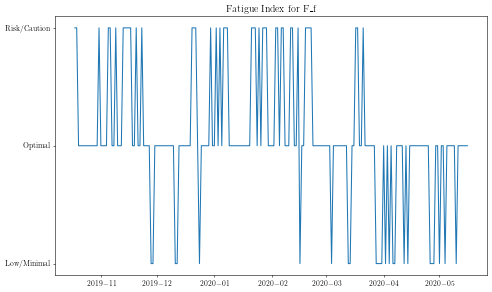

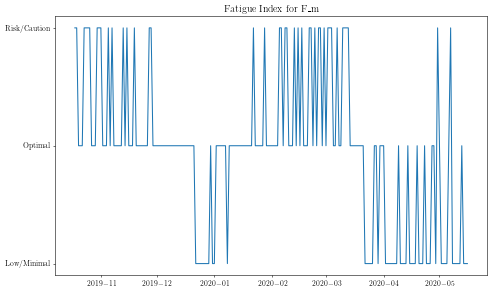

In [4]:
def shidshj(fatigue):
    if fatigue == "Risk/Caution":
        return 2
    elif fatigue == "Optimal":
        return 1
    else:
        return 0

for name in ["F_f", "F_m"]:#df["Name"].unique():
    plt.figure(figsize=(10, 6))
    df_name = df[df["Name"] == name]
    plt.plot(df_name["Date"], df_name["FatigInd"].map(shidshj), label=name)
    plt.title(f"Fatigue Index for {name}")
    plt.yticks(ticks=[0, 1, 2], labels=["Low/Minimal", "Optimal", "Risk/Caution"])
    plt.tight_layout()
    plt.savefig(f"assets/distribution_FatigInd({name}).png", transparent=True)
    plt.show()

In [5]:
# Brief description of the data
#df = df[['Name', 'Date', 'Sex_F', 'Appetite', 'SleepInd', 'StSpirit', 'pEffort',
#         'uaI', 'uaI(-1)', 'DeltaWt (%)', 'DeltaHrtwo', 'FatigInd']]
df.info()#.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1272 entries, 0 to 1271
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1272 non-null   datetime64[ns]
 1   Appetite          1183 non-null   float64       
 2   StSpirit          1183 non-null   float64       
 3   pEffort           1183 non-null   float64       
 4   uaI               1255 non-null   float64       
 5   FatigInd          1272 non-null   object        
 6   DeltaWt (%)       1265 non-null   float64       
 7   DeltaHrtwo        1171 non-null   float64       
 8   Name              1272 non-null   object        
 9   Sex_F             1272 non-null   int64         
 10  SleepInd          1185 non-null   float64       
 11  uaI(MA3)          1218 non-null   float64       
 12  SleepInd(MA3)     1143 non-null   float64       
 13  StSpirit(MA3)     1143 non-null   float64       
 14  pEffort(MA3)      1143 n

### Description of the variables


- *deltahrtwo - se modelo for mau, fazer apos2h - media do basal - 10

- *DeltaHrb

|  | Variables             | Simplified variable | Description                                                   | Scale     |
|--| --------------------- | ------------------- | ------------------------------------------------------------- | --------- |
|  |                       | All scales go from lowest (best feeling) to highest (worse feeling)                 |           |
| 0|                       | Name                | First letter of the athlete's name and sex                    |           |
| 1| Data                  | Date                | Date of the measure                                           | Ordinal   |
| 2|                       | Sex_F               | Athlete's gender                                              |           |
| 3| Apetite               | Appetite            | Measure of appetite throughout the day                        | 2 - 10    |
| 4| Índice de Sono        | SleepInd            | Calculated as function of quality of sleep and time in bed    | Ordinal   |
| 5| Estado de ânimo       | StSpirit            | State of spirit, motivation                                   | 2 - 10    |
| 6| Percepção de carga    | pEffort             | Perceived effort from the workout                             | 2 - 10    |
| 7| U. A. Intensidade     | uaI                 | Calculated int. from each workout, depending on type of exe.  | 1 - 5     |
| 8| U. A. Intensidade (ontem) | uaI(-1)         | uaI from the day before                                       | 1 - 5     |
| 9| Diferença peso        | DeltaWt (%)         | Percentual difference in weight in consecutive days           | 0 - 100   |
|10| Diferença pulso 2 hr  | DeltaHrtwo          | Delta of heart rate before and after the workout              | 2 - 10    |
|11| Índica de Fadiga      | FatigInd            | Calculated fatigue index from the variables above             | 0 - 100   |


In [6]:
df.isna().sum()

Date                  0
Appetite             89
StSpirit             89
pEffort              89
uaI                  17
FatigInd              0
DeltaWt (%)           7
DeltaHrtwo          101
Name                  0
Sex_F                 0
SleepInd             87
uaI(MA3)             54
SleepInd(MA3)       129
StSpirit(MA3)       129
pEffort(MA3)        129
DeltaWt (%)(MA3)      0
Appetite(MA3)       129
uaI(MA6)             54
SleepInd(MA6)       129
StSpirit(MA6)       129
pEffort(MA6)        129
DeltaWt (%)(MA6)      0
Appetite(MA6)       129
uaI(-1)              24
SleepInd(-1)         94
StSpirit(-1)         96
pEffort(-1)          96
DeltaWt (%)(-1)      14
Appetite(-1)         96
dtype: int64

## NaN

apos analisar as variaveis e os valores em falta, chegou-se a conclusao que o melhor seria remover obs com valores em falta

In [7]:
df.dropna(inplace=True)
df.isna().sum()

Date                0
Appetite            0
StSpirit            0
pEffort             0
uaI                 0
FatigInd            0
DeltaWt (%)         0
DeltaHrtwo          0
Name                0
Sex_F               0
SleepInd            0
uaI(MA3)            0
SleepInd(MA3)       0
StSpirit(MA3)       0
pEffort(MA3)        0
DeltaWt (%)(MA3)    0
Appetite(MA3)       0
uaI(MA6)            0
SleepInd(MA6)       0
StSpirit(MA6)       0
pEffort(MA6)        0
DeltaWt (%)(MA6)    0
Appetite(MA6)       0
uaI(-1)             0
SleepInd(-1)        0
StSpirit(-1)        0
pEffort(-1)         0
DeltaWt (%)(-1)     0
Appetite(-1)        0
dtype: int64

## dataset analysis pt.2 

ver qnt de tipos de fadiga e sexos

In [8]:
combinacoes = df.groupby(['FatigInd']).size().reset_index(name='contagem')
print(combinacoes)

       FatigInd  contagem
0   Low/Minimal       189
1       Optimal       727
2  Risk/Caution       213


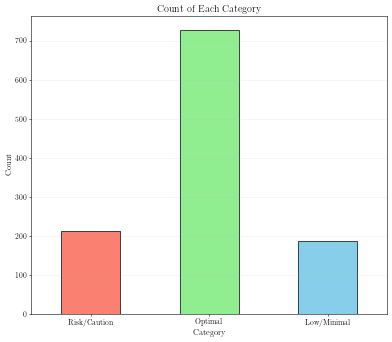

In [9]:
def plot_FATIGvsSEX(df):
    import matplotlib.pyplot as plt

    color_map = {
        'Risk/Caution': 'salmon',
        'Low/Minimal': 'skyblue',
        'Optimal': 'lightgreen'
        # Add more categories and their corresponding colors if needed
    }

    # Count occurrences of each category in FatigInd
    contagem = df['FatigInd'].value_counts()
    custom_order = ['Risk/Caution', 'Optimal', 'Low/Minimal']
    contagem = contagem[custom_order]
    
    colors = [color_map.get(cat, 'gray') for cat in contagem.index]

    

    # Plot the chart
    contagem.plot(kind='bar', color=colors, figsize=(8, 7))
    for patch in plt.gca().patches:  # Get all the bars in the current Axes
            patch.set_edgecolor('black')  # Set the edge color to black
            patch.set_linewidth(1)        # Set the width of the edge to 1
    plt.title('Count of Each Category')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.2)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'assets/distribution_FatigInd(0).png', transparent=True)
    plt.show()


plot_FATIGvsSEX(df)

In [10]:
# EQUALIZING THE CLASSES
classes = df["FatigInd"].unique()
target_count = 213

df_balanced = pd.DataFrame() 
for cls in classes:
    class_rows = df[df["FatigInd"] == cls]
    current_count = len(class_rows)
        
    if current_count < target_count:
        # If the class has fewer rows than target, add rows
        extra_needed = target_count - current_count
        sampled_rows = class_rows.sample(n=extra_needed, replace=True, random_state=42)
        df_balanced = pd.concat([df_balanced, class_rows, sampled_rows], ignore_index=True)

    elif current_count > target_count:
        # If the class has more rows than target, randomly remove rows
        sampled_rows = class_rows.sample(n=target_count, random_state=42)
        df_balanced = pd.concat([df_balanced, sampled_rows], ignore_index=True)

    else:
        # If the class is already at the target count, keep as is
        df_balanced = pd.concat([df_balanced, class_rows], ignore_index=True)
    

combinacoes = df_balanced.groupby(['FatigInd']).size().reset_index(name='contagem')
print(combinacoes)

       FatigInd  contagem
0   Low/Minimal       213
1       Optimal       213
2  Risk/Caution       213


In [11]:
df_balanced.to_csv('10ma.csv', index=False)